<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:35<00:00, 4.81MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


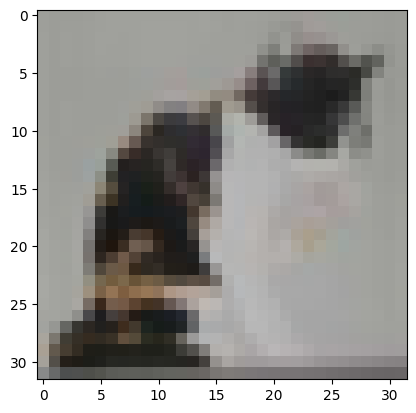

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

In [6]:
means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train)])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, _ = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [7]:
#Creating dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)

# **II. Model implementation**

In [10]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.ReLU())


  def forward(self, x):
    return self.conv_layer(x)

In [11]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [12]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers:
      x = fc_layer(x)
    return x


# **III. Training and test**

In [13]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 16)
out_channels = (16, 32)
conv_kernels = (5, 5)
fc_dims = (out_channels[-1]*5*5, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [14]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 117866
Device is cuda


In [15]:
if device=="cuda": model = torch.compile(model)

In [16]:
#Training and validation
nb_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
      if loss.item() < best_loss:
          best_loss = loss.item()
          best_model, best_epoch = model, epoch
    loss_val /= len(val_loader)
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()


Epoch: 0


782it [00:16, 47.54it/s]
79it [00:01, 65.30it/s]


Loss_train: 1.7531 and loss_val: 1.5205
Epoch: 1


782it [00:14, 55.24it/s]
79it [00:01, 67.85it/s]


Loss_train: 1.4636 and loss_val: 1.4128
Epoch: 2


782it [00:14, 54.92it/s]
79it [00:01, 68.61it/s]


Loss_train: 1.3668 and loss_val: 1.3438
Epoch: 3


782it [00:15, 50.08it/s]
79it [00:01, 69.78it/s]


Loss_train: 1.3011 and loss_val: 1.2815
Epoch: 4


782it [00:14, 55.64it/s]
79it [00:01, 67.79it/s]


Loss_train: 1.2485 and loss_val: 1.2454
Epoch: 5


782it [00:14, 54.97it/s]
79it [00:01, 69.64it/s]


Loss_train: 1.2040 and loss_val: 1.1989
Epoch: 6


782it [00:14, 55.10it/s]
79it [00:01, 46.31it/s]


Loss_train: 1.1661 and loss_val: 1.1773
Epoch: 7


782it [00:14, 55.09it/s]
79it [00:01, 64.85it/s]


Loss_train: 1.1347 and loss_val: 1.1659
Epoch: 8


782it [00:14, 55.19it/s]
79it [00:01, 64.68it/s]


Loss_train: 1.1068 and loss_val: 1.1287
Epoch: 9


782it [00:14, 54.22it/s]
79it [00:01, 67.00it/s]


Loss_train: 1.0794 and loss_val: 1.1151
Epoch: 10


782it [00:14, 52.23it/s]
79it [00:01, 65.07it/s]


Loss_train: 1.0557 and loss_val: 1.0963
Epoch: 11


782it [00:14, 54.68it/s]
79it [00:01, 69.26it/s]


Loss_train: 1.0343 and loss_val: 1.0794
Epoch: 12


782it [00:14, 55.63it/s]
79it [00:01, 69.85it/s]


Loss_train: 1.0159 and loss_val: 1.0732
Epoch: 13


782it [00:14, 55.66it/s]
79it [00:01, 47.37it/s]


Loss_train: 0.9989 and loss_val: 1.0625
Epoch: 14


782it [00:14, 55.45it/s]
79it [00:01, 69.06it/s]


Loss_train: 0.9839 and loss_val: 1.0423
Epoch: 15


782it [00:14, 55.86it/s]
79it [00:01, 69.77it/s]


Loss_train: 0.9723 and loss_val: 1.0464
Epoch: 16


782it [00:14, 54.92it/s]
79it [00:01, 69.74it/s]


Loss_train: 0.9566 and loss_val: 1.0397
Epoch: 17


782it [00:14, 54.42it/s]
79it [00:01, 50.75it/s]


Loss_train: 0.9451 and loss_val: 1.0267
Epoch: 18


782it [00:14, 55.43it/s]
79it [00:01, 64.10it/s]


Loss_train: 0.9345 and loss_val: 1.0257
Epoch: 19


782it [00:13, 55.89it/s]
79it [00:01, 70.04it/s]


Loss_train: 0.9255 and loss_val: 1.0076
Epoch: 20


782it [00:14, 55.42it/s]
79it [00:01, 68.06it/s]


Loss_train: 0.9144 and loss_val: 1.0137
Epoch: 21


782it [00:14, 52.95it/s]
79it [00:01, 66.99it/s]


Loss_train: 0.9054 and loss_val: 1.0007
Epoch: 22


782it [00:13, 56.00it/s]
79it [00:01, 72.13it/s]


Loss_train: 0.8980 and loss_val: 0.9942
Epoch: 23


782it [00:13, 56.81it/s]
79it [00:01, 70.14it/s]


Loss_train: 0.8901 and loss_val: 1.0019
Epoch: 24


782it [00:14, 55.40it/s]
79it [00:01, 55.95it/s]


Loss_train: 0.8808 and loss_val: 0.9890
Epoch: 25


782it [00:14, 53.92it/s]
79it [00:01, 66.58it/s]


Loss_train: 0.8752 and loss_val: 0.9952
Epoch: 26


782it [00:14, 55.79it/s]
79it [00:01, 69.29it/s]


Loss_train: 0.8673 and loss_val: 0.9786
Epoch: 27


782it [00:14, 55.81it/s]
79it [00:01, 68.00it/s]


Loss_train: 0.8609 and loss_val: 0.9915
Epoch: 28


782it [00:14, 55.03it/s]
79it [00:01, 46.83it/s]


Loss_train: 0.8547 and loss_val: 0.9704
Epoch: 29


782it [00:14, 55.79it/s]
79it [00:01, 67.37it/s]


Loss_train: 0.8481 and loss_val: 0.9839
Epoch: 30


782it [00:14, 55.01it/s]
79it [00:01, 68.78it/s]


Loss_train: 0.8443 and loss_val: 0.9749
Epoch: 31


782it [00:14, 55.66it/s]
79it [00:01, 67.84it/s]


Loss_train: 0.8369 and loss_val: 0.9757
Epoch: 32


782it [00:14, 53.39it/s]
79it [00:01, 57.13it/s]


Loss_train: 0.8307 and loss_val: 0.9670
Epoch: 33


782it [00:13, 56.01it/s]
79it [00:01, 69.02it/s]


Loss_train: 0.8243 and loss_val: 0.9644
Epoch: 34


782it [00:13, 55.97it/s]
79it [00:01, 70.46it/s]


Loss_train: 0.8204 and loss_val: 0.9675
Epoch: 35


782it [00:13, 56.15it/s]
79it [00:01, 67.32it/s]


Loss_train: 0.8152 and loss_val: 0.9599
Epoch: 36


782it [00:16, 47.89it/s]
79it [00:01, 59.51it/s]


Loss_train: 0.8100 and loss_val: 0.9678
Epoch: 37


782it [00:19, 40.83it/s]
79it [00:01, 57.26it/s]


Loss_train: 0.8066 and loss_val: 0.9629
Epoch: 38


782it [00:17, 44.83it/s]
79it [00:01, 69.72it/s]


Loss_train: 0.8002 and loss_val: 0.9639
Epoch: 39


782it [00:14, 52.75it/s]
79it [00:01, 70.17it/s]


Loss_train: 0.7971 and loss_val: 0.9565
Epoch: 40


782it [00:13, 57.09it/s]
79it [00:01, 50.49it/s]


Loss_train: 0.7912 and loss_val: 0.9542
Epoch: 41


782it [00:13, 57.56it/s]
79it [00:01, 71.58it/s]


Loss_train: 0.7890 and loss_val: 0.9635
Epoch: 42


782it [00:13, 57.89it/s]
79it [00:01, 70.07it/s]


Loss_train: 0.7850 and loss_val: 0.9539
Epoch: 43


782it [00:13, 56.75it/s]
79it [00:01, 69.88it/s]


Loss_train: 0.7819 and loss_val: 0.9501
Epoch: 44


782it [00:13, 57.46it/s]
79it [00:01, 53.36it/s]


Loss_train: 0.7769 and loss_val: 0.9532
Epoch: 45


782it [00:13, 56.41it/s]
79it [00:01, 72.03it/s]


Loss_train: 0.7737 and loss_val: 0.9629
Epoch: 46


782it [00:14, 54.21it/s]
79it [00:01, 71.30it/s]


Loss_train: 0.7700 and loss_val: 0.9576
Epoch: 47


782it [00:13, 57.04it/s]
79it [00:01, 67.95it/s]


Loss_train: 0.7666 and loss_val: 0.9632
Epoch: 48


782it [00:14, 55.01it/s]
79it [00:01, 48.79it/s]


Loss_train: 0.7634 and loss_val: 0.9527
Epoch: 49


782it [00:13, 57.80it/s]
79it [00:01, 73.41it/s]


Loss_train: 0.7586 and loss_val: 0.9586
Epoch: 50


782it [00:13, 57.83it/s]
79it [00:01, 68.48it/s]


Loss_train: 0.7565 and loss_val: 0.9559
Epoch: 51


782it [00:14, 55.72it/s]
79it [00:01, 69.78it/s]


Loss_train: 0.7525 and loss_val: 0.9480
Epoch: 52


782it [00:13, 56.72it/s]
79it [00:01, 49.43it/s]


Loss_train: 0.7504 and loss_val: 0.9530
Epoch: 53


782it [00:14, 55.48it/s]
79it [00:01, 69.65it/s]


Loss_train: 0.7474 and loss_val: 0.9463
Epoch: 54


782it [00:13, 56.49it/s]
79it [00:01, 70.89it/s]


Loss_train: 0.7436 and loss_val: 0.9503
Epoch: 55


782it [00:13, 56.46it/s]
79it [00:01, 69.82it/s]


Loss_train: 0.7412 and loss_val: 0.9490
Epoch: 56


782it [00:13, 56.99it/s]
79it [00:01, 50.22it/s]


Loss_train: 0.7389 and loss_val: 0.9511
Epoch: 57


782it [00:14, 55.39it/s]
79it [00:01, 70.00it/s]


Loss_train: 0.7365 and loss_val: 0.9490
Epoch: 58


782it [00:13, 56.51it/s]
79it [00:01, 67.01it/s]


Loss_train: 0.7330 and loss_val: 0.9569
Epoch: 59


782it [00:14, 55.35it/s]
79it [00:01, 70.30it/s]


Loss_train: 0.7307 and loss_val: 0.9467
Epoch: 60


782it [00:14, 55.21it/s]
79it [00:01, 47.38it/s]


Loss_train: 0.7272 and loss_val: 0.9581
Epoch: 61


245it [00:04, 57.66it/s]


KeyboardInterrupt: 

Time elapsed: 43.40467429161072
Seconds per epoch: 0.4340467429161072
Best epoch: 61


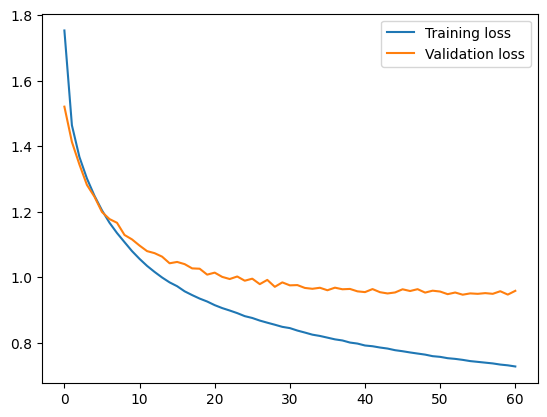

In [19]:
end = time()
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {epoch}")

epochs = range(61)

plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [20]:
#Test on val data
model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(val_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(val_loader)

  print(f"Loss_test: {loss_test:.4f}")

Now testing...


79it [00:02, 28.88it/s]

Loss_test: 0.9476


<Axes: >

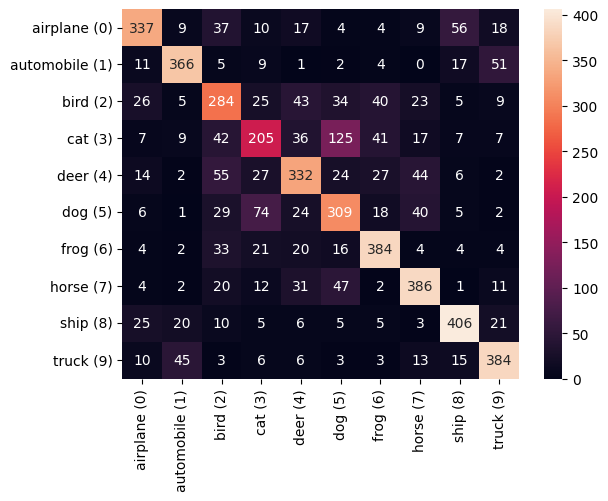

In [21]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [22]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.6786


In [24]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)
print("Mean of accuracies: ", accuracies_df["Accuracy"].mean())

                Accuracy
ship (8)        0.802372
truck (9)       0.786885
automobile (1)  0.785408
frog (6)        0.780488
horse (7)       0.748062
airplane (0)    0.672655
deer (4)        0.622889
dog (5)         0.608268
bird (2)        0.574899
cat (3)         0.413306
Mean of accuracies:  0.6795231283115764
